# Facial Emotion Recognition - Project

## Import Modules

In [20]:
# https://www.youtube.com/watch?v=mj-3vzJ4ZVw&ab_channel=HackersRealm
import os
import zipfile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
# import warnings
# warnings.filterwarnings('ignore')
# %matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

from collections import Counter
from PIL import Image
from google.colab import files
from google.colab import drive

## Load the Dataset

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
ZIP_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/Project/dataset/archive.zip'

DATASET_PATH = '/dataset'
TRAIN_DATASET_PATH = '/dataset/train/train'
TEST_DATASET_PATH = '/dataset/test/test'

MODEL_OUTPUT_PATH = '/content/drive/MyDrive/Colab Notebooks/Project/model.h5'

In [22]:
with zipfile.ZipFile(ZIP_DATASET_PATH, 'r') as zip_ref:
    zip_ref.extractall(DATASET_PATH)

In [23]:
print(os.listdir(TRAIN_DATASET_PATH))

['sad', 'disgust', 'happy', 'surprise', 'neutral', 'fear', 'angry']


In [24]:
def load_dataset(directory):
    images = list()
    labels = list()

    for label in os.listdir(directory):
        emotion_path = os.path.join(directory, label)
        for filename in os.listdir(emotion_path):
            image_path = os.path.join(emotion_path, filename)

            images.append(image_path)
            labels.append(label)

    return images, labels

In [25]:
train = pd.DataFrame()
test = pd.DataFrame()

train['image'], train['label'] = load_dataset(TRAIN_DATASET_PATH)
train = train.sample(frac=1).reset_index(drop=True)

test['image'], test['label'] = load_dataset(TEST_DATASET_PATH)

In [26]:
train.head()

,image,label
0,/dataset/train/train/neutral/Training_53590006...,neutral
1,/dataset/train/train/happy/Training_31440821.jpg,happy
2,/dataset/train/train/happy/Training_69896351.jpg,happy
3,/dataset/train/train/sad/Training_20786330.jpg,sad
4,/dataset/train/train/surprise/Training_9516359...,surprise


In [ ]:
test.head()

,image,label
0,/dataset/test/test/sad/PublicTest_99116679.jpg,sad
1,/dataset/test/test/sad/PrivateTest_47084428.jpg,sad
2,/dataset/test/test/sad/PublicTest_20224413.jpg,sad
3,/dataset/test/test/sad/PublicTest_62517424.jpg,sad
4,/dataset/test/test/sad/PrivateTest_45035815.jpg,sad


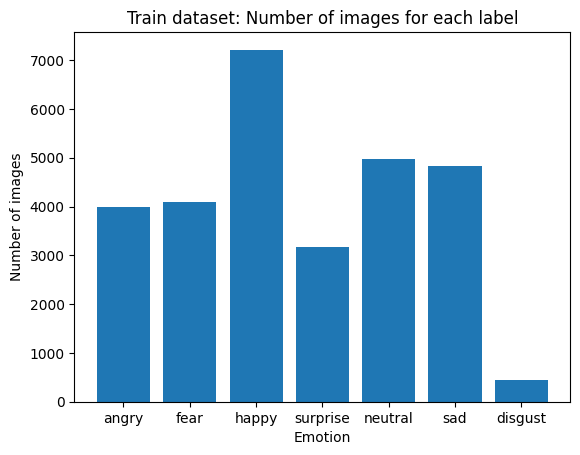

In [ ]:
emotions_counter = Counter(train['label'])
plt.bar(emotions_counter.keys(), emotions_counter.values())

plt.title('Train dataset: Number of images for each label')
plt.xlabel('Emotion')
plt.ylabel('Number of images')

plt.show()

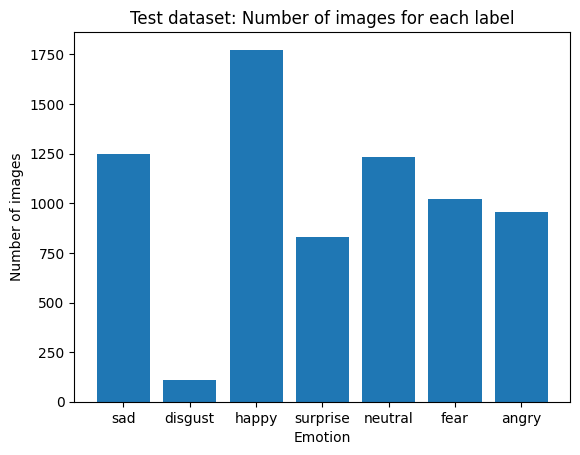

In [ ]:
emotions_counter = Counter(test['label'])
plt.bar(emotions_counter.keys(), emotions_counter.values())

plt.title('Test dataset: Number of images for each label')
plt.xlabel('Emotion')
plt.ylabel('Number of images')

plt.show()

Text(0.5, 1.0, 'angry')

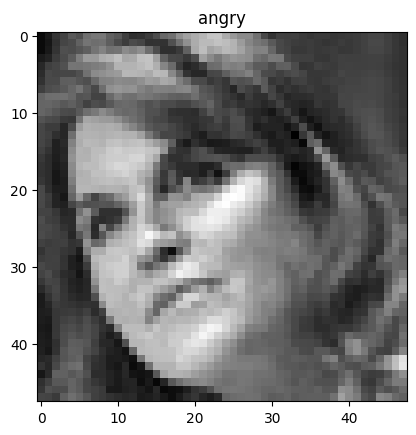

In [ ]:
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');
plt.title(train['label'][0])

## Translate images

In [27]:
def extract_features(images_paths):
    images = list()

    for image_path in images_paths:
        image = load_img(image_path, grayscale=True)
        images.append(np.array(image))

    images = np.array(images)
    images = images.reshape(len(images), 48, 48, 1)

    return images

In [28]:
x_train = extract_features(train['image'])
x_train = x_train / 255.0

x_test = extract_features(test['image'])
x_test = x_test / 255.0

/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [29]:
print(x_train[0])

[[[0.02352941]
  [0.03137255]
  [0.02352941]
  ...
  [0.90588235]
  [0.88627451]
  [0.88627451]]

 [[0.02745098]
  [0.03137255]
  [0.03137255]
  ...
  [0.8745098 ]
  [0.87843137]
  [0.90196078]]

 [[0.02745098]
  [0.02745098]
  [0.03529412]
  ...
  [0.86666667]
  [0.87843137]
  [0.89411765]]

 ...

 [[0.03137255]
  [0.03137255]
  [0.03137255]
  ...
  [0.65098039]
  [0.67843137]
  [0.70196078]]

 [[0.03137255]
  [0.03137255]
  [0.03137255]
  ...
  [0.79215686]
  [0.78431373]
  [0.76862745]]

 [[0.02745098]
  [0.02745098]
  [0.03137255]
  ...
  [0.76862745]
  [0.78039216]
  [0.8       ]]]


In [30]:
label_encoder = LabelEncoder()
label_encoder.fit(train['label'])

LabelEncoder()

In [31]:
y_train = label_encoder.transform(train['label'])
y_train = to_categorical(y_train, num_classes=7)

y_test = label_encoder.transform(test['label'])
y_test = to_categorical(y_test, num_classes=7)

In [44]:
y_train[0: 2]

array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

## Train model

In [42]:
def get_model():
    model = Sequential()

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

    return model

In [45]:
model = get_model()
predicted = model.fit(x=x_train, y=y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
225/225 [==============================] - 15s 56ms/step - loss: 1.8237 - accuracy: 0.2463 - val_loss: 1.8141 - val_accuracy: 0.2471
Epoch 2/50
225/225 [==============================] - 11s 51ms/step - loss: 1.8103 - accuracy: 0.2518 - val_loss: 1.7947 - val_accuracy: 0.2509
Epoch 3/50
225/225 [==============================] - 11s 50ms/step - loss: 1.7650 - accuracy: 0.2666 - val_loss: 1.7025 - val_accuracy: 0.3076
Epoch 4/50
225/225 [==============================] - 11s 51ms/step - loss: 1.6736 - accuracy: 0.3256 - val_loss: 1.5648 - val_accuracy: 0.3977
Epoch 5/50
225/225 [==============================] - 11s 51ms/step - loss: 1.5621 - accuracy: 0.3880 - val_loss: 1.4306 - val_accuracy: 0.4419
Epoch 6/50
225/225 [==============================] - 11s 51ms/step - loss: 1.4939 - accuracy: 0.4203 - val_loss: 1.3780 - val_accuracy: 0.4765
Epoch 7/50
225/225 [==============================] - 11s 51ms/step - loss: 1.4329 - accuracy: 0.4485 - val_loss: 1.3077 - val_accuracy:

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=get_model)

params = {
    'layers': [[128, 32], [128, 64, 32], [64, 32]],
    'batch_size': [32, 64],
    'epochs': [10, 20, 30]
}

# grid = GridSearchCV(estimator=model, param_grid=params, cv=3)
# grid_result = grid.fit(x_train, y_train)

## Test model

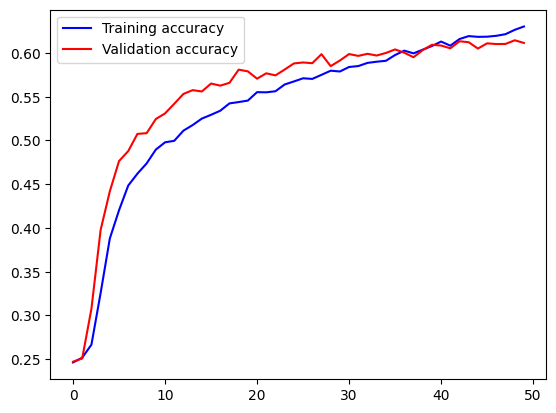

In [46]:
accuracy = predicted.history['accuracy']
val_accuracy = predicted.history['val_accuracy']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.legend()

plt.show()

In [32]:
def predict_random_image():
    image_index = random.randint(0, len(test))

    image = x_test[image_index]
    expected_result = test['label'][image_index]

    result = model.predict(image.reshape(1, 48, 48, 1))
    best_label_index = result.argmax()
    predicted_result = label_encoder.inverse_transform([best_label_index])[0]

    print(f'Expected result: {expected_result}')
    print(f'Predicted result: {predicted_result}')
    plt.imshow(image.reshape(48, 48), cmap='gray');

1/1 [==============================] - 0s 21ms/step
Expected result: sad
Predicted result: sad


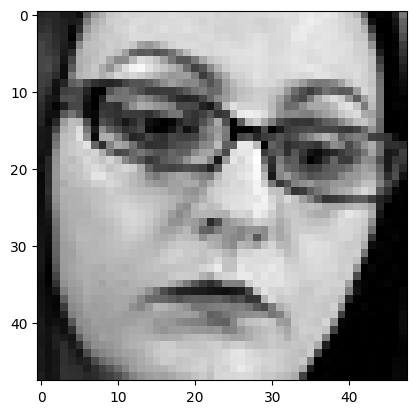

In [34]:
predict_random_image()

## Save the model

In [47]:
model.save(MODEL_OUTPUT_PATH)

In [5]:
from keras.models import load_model
model = load_model(MODEL_OUTPUT_PATH)

In [41]:
IMAGE_PATH_TEST = '/content/drive/MyDrive/Colab Notebooks/Project/dataset/test_happy.jpg'
image = Image.open(IMAGE_PATH_TEST)
print(image)

image = np.array(image)
image = image / 255.0
print(image)
image = image.reshape(1, 48, 48, 1)



result = model.predict(image)

best_label_index = result.argmax()
predicted_result = label_encoder.inverse_transform([best_label_index])[0]

print(predicted_result)

<PIL.JpegImagePlugin.JpegImageFile image mode=L size=48x48 at 0x7F5B1249C1F0>
[[0.54901961 0.55294118 0.54117647 ... 0.01176471 0.00784314 0.02352941]
 [0.55294118 0.54509804 0.54901961 ... 0.02745098 0.01960784 0.02352941]
 [0.56078431 0.54117647 0.55294118 ... 0.01960784 0.01568627 0.02745098]
 ...
 [0.54509804 0.55294118 0.54901961 ... 0.22352941 0.09411765 0.10980392]
 [0.53333333 0.55294118 0.55686275 ... 0.14901961 0.09411765 0.11372549]
 [0.51764706 0.54901961 0.56078431 ... 0.09803922 0.11764706 0.09803922]]
1/1 [==============================] - 0s 19ms/step
happy
